## Dataset

Veamos estadísticas y otras cosas del dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


dataset_articles = annotated_articles.filter(effective_labels=3)

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {dataset_articles.count()}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1738
Artículos con 3 anotaciones: 1238
Artículos con alguna anotación: 1725
Artículos que no pasaron a tercera anotación: 452


Carguemos directamente el JSON generado

In [3]:
import json

with open("../output/dataset.raw.json") as f:
    articles = json.load(f)
print(len(articles))
articles[0].keys()


1238


dict_keys(['tweet_id', 'title', 'tweet_text', 'body', 'news', 'date', 'comments'])

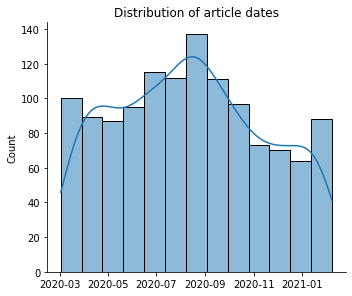

In [4]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

dates = [datetime.fromisoformat(d["date"].replace('Z', '+00:00')) for d in articles]

ax = sns.displot(
    x=dates, 
    kde=True, 
    height=4, aspect=1.25,
)

plt.title("Distribution of article dates")
plt.savefig("figures/date_distribution.png", bbox_inches='tight')

In [5]:
from django.db.models import Sum
import pandas as pd

df_articles = pd.DataFrame(articles)
df_articles.set_index("tweet_id", inplace=True)

df_articles["comments"] = df_articles["comments"].apply(lambda l: len(l))
q = Article.objects.filter(id__in=[d.id for d in dataset_articles])


df_count = df_articles.groupby("news")[["comments"]].sum()
df_count["articles"] = df_articles.groupby("news")["comments"].count()


df_count.loc["total"] = df_count.sum()

df_count

,comments,articles
news,,
LANACION,10378,222
clarincom,17501,370
cronica,1562,42
infobae,26834,590
perfilcom,594,14
total,56869,1238


In [6]:
print(df_count.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  comments &  articles \\
news      &           &           \\
\midrule
LANACION  &     10378 &       222 \\
clarincom &     17501 &       370 \\
cronica   &      1562 &        42 \\
infobae   &     26834 &       590 \\
perfilcom &       594 &        14 \\
total     &     56869 &      1238 \\
\bottomrule
\end{tabular}



In [7]:
articles[0]["comments"][0]

{'id': 327916,
 'text': '@usuario Momento oportuno para hacer esa movida!!!!..ahora que la JUSTICIA está en veda sanitaria..!!!!..',
 'article_id': '1241486782178435072',
 'annotators': ['annotator_5', 'annotator_2'],
 'HATEFUL': [],
 'CALLS': [],
 'WOMEN': [],
 'LGBTI': [],
 'RACISM': [],
 'CLASS': [],
 'POLITICS': [],
 'DISABLED': [],
 'APPEARANCE': [],
 'CRIMINAL': [],
 'tweet_id': '1241513939499876354',
 'user_id': '1173653523478851593'}

In [8]:


comments = [
{
    **{"article_id": art["tweet_id"]},
    **comment
} for art in articles for comment in art["comments"]]


[]

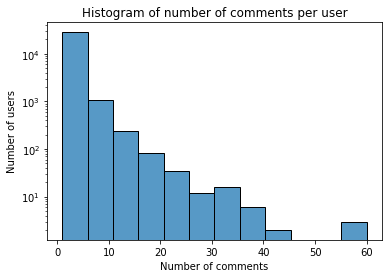

In [9]:
user_counts = pd.DataFrame(comments)["user_id"].value_counts().to_frame("number of comments")
sns.histplot(data=user_counts, x="number of comments", hue=None, bins=12)

plt.ylabel("Number of users")
plt.xlabel("Number of comments")
plt.title("Histogram of number of comments per user")
plt.semilogy()

In [10]:
comments[0]

{'article_id': '1241486782178435072',
 'id': 327916,
 'text': '@usuario Momento oportuno para hacer esa movida!!!!..ahora que la JUSTICIA está en veda sanitaria..!!!!..',
 'annotators': ['annotator_5', 'annotator_2'],
 'HATEFUL': [],
 'CALLS': [],
 'WOMEN': [],
 'LGBTI': [],
 'RACISM': [],
 'CLASS': [],
 'POLITICS': [],
 'DISABLED': [],
 'APPEARANCE': [],
 'CRIMINAL': [],
 'tweet_id': '1241513939499876354',
 'user_id': '1173653523478851593'}

Text(0.5, 1.0, 'Histogram of hateful annotations per comment')

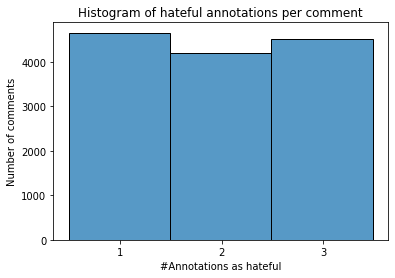

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

votes = [len(c['HATEFUL']) for c in comments if c['HATEFUL']]

sns.histplot(x=votes, bins=[0.99, 1.99, 2.99, 3.99])

plt.xticks([1.5, 2.5, 3.5], [1, 2, 3])
plt.xlabel("#Annotations as hateful")
plt.ylabel("Number of comments")
plt.title("Histogram of hateful annotations per comment")

In [12]:
possibly_hateful = len([c for c in comments if len(c['HATEFUL']) > 0])
hateful = len([c for c in comments if len(c['HATEFUL']) >= 2])

full_agreement = len([c for c in comments if len(c['HATEFUL']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos (>= 2) sobre totales = {hateful / len(comments):.3f}")

Comentarios totales                             : 56869
Comentarios con >= 1 etiqueta de discriminación : 13366
Comentarios con >= 2 etiqueta de discriminación : 8715
Comentarios con >= 3 etiqueta de discriminación : 4514
Ratio de comentarios odiosos (>= 2) sobre totales = 0.153


## Agreement

Uso el código que ya hice con los objetos de Django que es más cómodo...

In [13]:
from api.metrics import AgreementCalculator

calculator = AgreementCalculator(articles=dataset_articles)

In [14]:
calculator.users = None

In [15]:
categories = [
    'HATE',
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category")

,Agreement
Category,
HATE,0.579610
CALLS,0.641360
MUJER,0.783391
LGBTI,0.920701
RACISMO,0.929094
POBREZA,0.706778
DISCAPACIDAD,0.849856
POLITICA,0.808519
ASPECTO,0.871752


Lo calculamos de nuevo por si acaso

In [16]:


keys = [
 'HATEFUL',
 'CALLS',
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL',
]

annotators = set(annotator for article in articles for comment in article["comments"] for annotator in comment["annotators"])

idx = pd.MultiIndex.from_product(
    [keys, annotators],
    names=["categoria", "etiquetador"]
)
comment_ids = [comment["id"] for article in articles for comment in article["comments"]]

my_df = pd.DataFrame(index=idx, columns=comment_ids)

for article in tqdm(articles):
    for comment in article["comments"]:
        for annotator in comment["annotators"]:
            is_hateful = annotator in comment["HATEFUL"]
            my_df.loc[("HATEFUL", annotator), comment["id"]] = is_hateful
            
            if is_hateful:
                for key in keys[1:]:
                    my_df.loc[(key, annotator), comment["id"]] =  annotator in comment[key]

  0%|          | 0/1238 [00:00<?, ?it/s]

In [17]:
import krippendorff

alphas = {key:krippendorff.alpha(my_df.loc[key].values.astype(float)) for key in keys}

pd.DataFrame([alphas]).T
    


,0
HATEFUL,0.579610
CALLS,0.641360
WOMEN,0.783391
LGBTI,0.920701
RACISM,0.929094
CLASS,0.706778
POLITICS,0.808519
DISABLED,0.849856
APPEARANCE,0.871752
CRIMINAL,0.931163


Obs: acá los agreements por categorías se ven sólo en aquellos comentarios que son marcados como odiosos, y sólo entre aquellos anotadores que hayan marcado como odioso

En términos de cómo calculamos el alpha de Krippendorff: supongamos que estamos calculando el agreement de MUJER. Si anotador A1 y A2 marcaron como odioso C1, y ambos marcaron mujer => en ambos va 1. Anotador A3 no marcó como odioso ese comentario => va nan. En C2, A1 no marcó como odioso y A2 y A3 marcaron como odioso contra MUJER. En C3, A3 no marcó odioso, y A1 sí pero sin marcar MUJER y A2 marcó odioso y MUJER.

La matriz quedaría así:

|   |C1   |C2    | C3   |
|---|-----|------|------|
|A1 | 1   | nan  | 0    |
|A2 | 1   | 1    | 1    |
|A3 | nan | 1    | nan  |

## Algunos ejemplos

Leamos ahora el ya asignado

In [18]:
with open("../output/dataset.json") as f:
    articles = json.load(f)
    
comments = [{**comm, **{"article": art}} for art in articles for comm in art["comments"]]

In [66]:
import random

char_tweets = {char:[] for char in keys[1:]}

for comment in comments:
    for key in char_tweets:
        if comment[key]:
            char_tweets[key].append(comment)

#for arr in char_tweets.values():
#    random.shuffle(arr)

df_count = pd.DataFrame([{k:len(v) for k, v in char_tweets.items()}]).T

df_count.columns = ["count"]

df_count.sort_values("count", ascending=False)

,count
RACISM,2469
APPEARANCE,1803
CRIMINAL,1642
CALLS,1451
POLITICS,1428
WOMEN,1332
CLASS,823
LGBTI,818
DISABLED,580


In [68]:
import random

random.seed(2021)

data = []

selected_ids = {
    "WOMEN": [407976, 371887, 407372, 350369, 404390, 354563],
    "LGBTI": [348304, 401013, 396655, 369370, 365953, 397528, 377415, 394007],
    "RACISM": [345526, 346189, 361417, 348501, 407751, 403677, 376555, 342786],
    "CRIMINAL": [],
    "CLASS": [344236, 335045, 355946, 379401, 345243, 353042],
    
    "POLITICS": [],
    "APPEARANCE": [],
    "DISABLED": [],
    
    
    "CALLS": [345395, 361092, 370678, 339375, 403667, 379905, 370694],
}

for char, tweets in char_tweets.items():
    print(f"\n\n## {char}", "\n" * 3)
    random.shuffle(tweets)
    for tweet in tweets[:25]:
        article = tweet["article"]
        print(f"- ({tweet['id']}) {tweet['text']} |||| {article['title']}")
        data.append({
            "article_id": article['tweet_id'],
            "comment_id": comment["id"],
            "characteristic": char,
            "text": tweet['text'], 
            "context": article['title'],
        })



## CALLS 



- (367970) @usuario Para esta gente debe haber pena de muerte |||| Abuso sexual, quemaduras de cigarrillo y duchas heladas: el bestial crimen de Sofía, la nena de 3 años torturada por su mamá y su padrastro
- (379350) @usuario No , se resuelve con un misil |||| Las organizaciones sociales salieron al cruce de la acusación de Sergio Berni por la toma de tierras: “La falta de vivienda no se resuelve con balas”
- (340921) @usuario No tiene nada de insólito en lo absoluto. Estos salvajes con su mugrosa cultura de la suciedad y el mal vivir crearon esta situación. Ahora que paguen! |||| Coronavirus en Alemania: la insólita factura de 160 mil millones de dólares a China por los “daños ocasionados” por la pandemia
- (351912) @usuario aprovechen y maten a todos esos delincuentes |||| Tras más de nueve horas, los presos levantaron el violento motín en la cárcel de Villa Devoto
- (347653) @usuario Todas las NACIÓNES deberían unirse para SANCIONAR FUERTEMENTE AL RÉGIMEN ASESINO CHI

In [42]:
df_char.iloc[0].text

'@usuario habrá alguna manera de erradicar a estos tipos del mundo ?'

In [63]:
import re
pd.options.display.max_colwidth = 256



sub_data = [d for d in data if d["characteristic"] in {"WOMEN", "LGBTI"}]

df_char = pd.DataFrame(sub_data)[["characteristic", "text", "context"]]

table = df_char.to_latex(index=False, col_space=1)

table = re.sub(r"&\s+", "& ", table)

print(table)

\begin{tabular}{lll}
\toprule
characteristic & text & context \\
\midrule
         WOMEN & @usuario Y como te quedó el ogt?. & Loly Antoniale mostró su impresionante casa en Miami: “Soy la reina de mi castillo” \\
         WOMEN & @usuario Habla el agua viva esta vestida de verde ? & Cecilia Moreau: "No se puede permitir que la minoría le imponga a la mayoría qué temas discutir" \\
         WOMEN & @usuario “Feminista interseccional”..:nos vamos a la mierda... & Empezó con una “relación abierta en lo sexual”, escaló al poliamor y da las claves para probar el amor libre \\
         WOMEN & @usuario Provocador ? A mi me provoca ganas de vomitar & ¡El sensual y provocador topless de Morena Rial! \\
         WOMEN & @usuario Que se aborte ella, vieja  bruja y degenerada!! & Martha Rosenberg: “En situación de pandemia, legalizar el aborto es más urgente que nunca” \\
         WOMEN & @usuario Kien es la feminista resentida q está instaurando esa idea desde hace días?? & Femicidio en Catamar

In [62]:
data[0]

{'article_id': '1245748490942152705',
 'comment_id': 407954,
 'characteristic': 'CALLS',
 'text': '@usuario habrá alguna manera de erradicar a estos tipos del mundo ?',
 'context': 'Coronavirus en China: la ciudad de Shenzhen prohíbe comer perros y gatos'}